In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
starbucks = pd.read_csv('data/starbucks.csv')
air = pd.read_csv('data/airline_passengers.csv')
price = pd.read_csv('data/price_of_ground_chuck.csv')

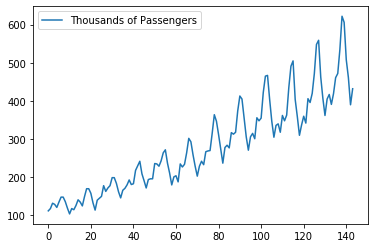

In [140]:
air.plot()
plt.show()

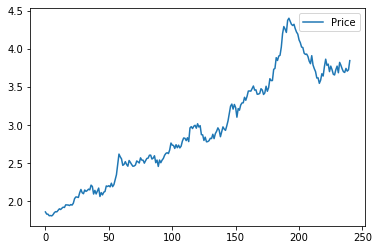

In [141]:
price.plot()
plt.show()

## 0. Exponential smoothing
- weights decaying exponentially as the observations get older

## 7.1 Simple exponential smoothing
- For forecasting data with no clear trend and seasonal pattern

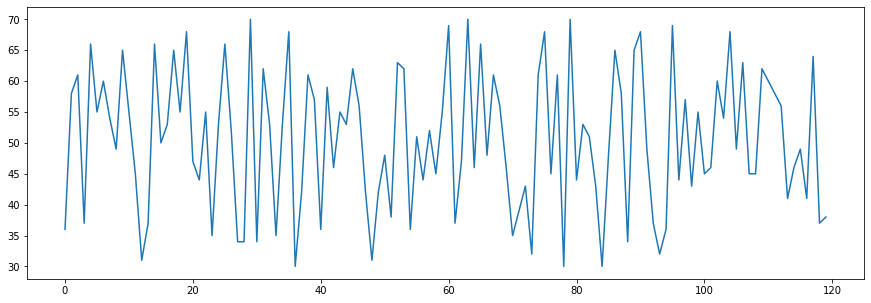

In [49]:
# no trend, no seasonal
ses = pd.read_csv('data/samples.csv')
ses['Unnamed: 0'] = pd.to_datetime(ses['Unnamed: 0'], dayfirst=True)
ses.columns.values[0] = 'Date'

ses['a'].plot(figsize=(15,5))
plt.show()

- Weighted average form
    - $\hat{y}_{t+1|t} = \alpha y_t + (1-\alpha) \hat{y}_{t|t-1}$
    - $= \alpha y_t + \alpha(1-\alpha)y_{t-1} + \alpha(1-\alpha)^2 y_{t-2} + ... + (1-\alpha)^{t-1}y_1 + (1-\alpha)^t l_0$
- Component form 
    - Forecast equation : $\hat{y}_{t+h|t} = l_t$ (flat forecast function! all forecast take the same value)
    - Smoothing equation : $l_t = \alpha y_t + (1-\alpha) l_{t-1}$
- Optimization
    - we have find $\alpha, l_0$ !
    - By minimizing the SSE

In [45]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

alpha = [0.3, 0.5, 0.7]

# model fitting
ses0 = SimpleExpSmoothing(ses['a']).fit(smoothing_level=alpha[0],optimized=False)
ses1 = SimpleExpSmoothing(ses['a']).fit(smoothing_level=alpha[1],optimized=False)
ses2 = SimpleExpSmoothing(ses['a']).fit(smoothing_level=alpha[2],optimized=False)

In [155]:
# SSE
print(f'SSE0 = {ses0.sse}, SSE1 = {ses1.sse}, SSE2 = {ses2.sse}')

SSE0 = 19647.88339320721, SSE1 = 22285.87480818881, SSE2 = 25785.388360177552


In [178]:
# BIC
print(f'SSE0 = {ses0.bic}, SSE1 = {ses1.bic}, SSE2 = {ses2.bic}')

SSE0 = 621.3629618881921, SSE1 = 636.4809751615547, SSE2 = 653.9835664935229


In [46]:
# Foreacast
print(f'Forecast 3:\n{ses0.forecast(3)}')

Forecast 3:
120    44.738484
121    44.738484
122    44.738484
dtype: float64


In [50]:
# Fitted values
ses['ses0'] = ses0.fittedvalues
ses['ses1'] = ses1.fittedvalues
ses['ses2'] = ses2.fittedvalues

print(ses.head(3))
print(ses.tail(3))

        Date   a   b  c   d  ses0  ses1  ses2
0 1950-01-01  36  27  0  67  36.0  36.0  36.0
1 1950-01-02  58  22  3  31  36.0  36.0  36.0
2 1950-01-03  61  17  5  67  42.6  47.0  51.4
          Date   a   b      c   d       ses0       ses1       ses2
117 1959-01-10  64  70   9667  42  47.115115  44.619114  43.122229
118 1959-01-11  37  87   9833  62  52.180580  54.309557  57.736669
119 1959-01-12  38  73  10000  50  47.626406  45.654778  43.221001


In [177]:
# model summary
ses0.summary()

Dep. Variable:,endog,No. Observations:,120
Model:,SimpleExpSmoothing,SSE,19647.883
Optimized:,False,AIC,615.788
Trend:,None,BIC,621.363
Seasonal:,None,AICC,616.136
Seasonal Periods:,None,Date:,"Wed, 08 Jul 2020"
Box-Cox:,False,Time:,07:56:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
initial_level,36.000000,l.0,False


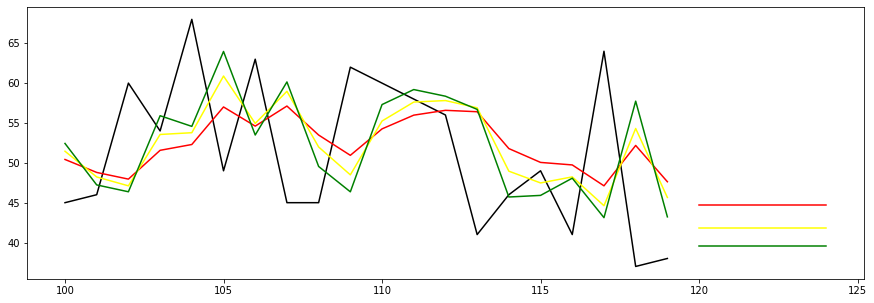

In [72]:
ses['a'][100:].plot(color='black', figsize=(15,5))

ses['ses0'][100:].plot(color='red')
ses0.forecast(5).plot(color='red')

ses['ses1'][100:].plot(color='yellow')
ses1.forecast(5).plot(color='yellow')

ses['ses2'][100:].plot(color='green')
ses2.forecast(5).plot(color='green')

plt.show()

In [64]:
# automatically find alpha
autoses = SimpleExpSmoothing(ses['a']).fit(optimized=True)

autoses.model.params

{'smoothing_level': 0.0,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 50.54166314578341,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## 7.2 Trend methods

### Holt's linear trend method
- Forecast of data with a trend

- Forecast equation : $\hat{y}_{t+h|t} = l_t + h b_t$
- Level equation : $l_t = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1})$
- Trend equation : $b_t = \beta(l_t - l_{t-1})+(1-\beta)b_{t-1}$
    - $l_t$ : an estimate of the level of the series at time t
    - $b_t$ : an estimate of the trend (slope) of the series at time t

### Damped trend methods
- Holt's linear method
    - display a constant trend indefinitely into the future
    - tend to over-forecast, expecially for longer forecast horizons
- So, introduce a parameter that 'dampens' the trend to a flat line in the future! : $\phi$

- Forecast equation : $\hat{y}_{t+h|t} = l_t + (\phi + \phi^2 + ... + \phi^h)b_t$
- Level equation : $l_t = \alpha y_t + (1-\alpha)(l_{t-1} + \phi b_{t-1})$
- Trend equation : $b_t = \beta(l_t - l_{t-1})+(1-\beta)\phi b_{t-1}$
    - usually $0.8 < \phi < 0.98$

Forecast converge to $l_t + \frac{\phi}{1-\phi} b_t$ as $h \rightarrow \infty$ !!

In [77]:
from statsmodels.tsa.holtwinters import Holt

In [147]:
price['Month'] = pd.to_datetime(price['Month'], dayfirst=False)
priceM = price.iloc[:,1]

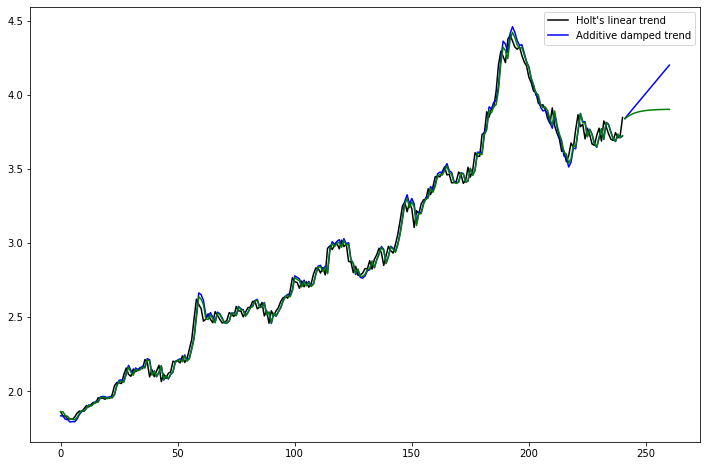

In [151]:
fit0 = Holt(priceM).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast0 = fit0.forecast(20).rename("Holt's linear trend")

fit1 = Holt(priceM, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast1 = fit1.forecast(20).rename("Additive damped trend")

priceM.plot(color="black", figsize=(12,8))

fit0.fittedvalues.plot(color='blue')
fcast0.plot(color='blue', legend=True)

fit1.fittedvalues.plot(color='green')
fcast1.plot(color='green', legend=True)

plt.show()

## 7.3 Holt-Winters' seasonal method
- extend Holt's method to capture seasonality
- level $l_t$, trend $b_t$, seasonal $s_t$
- $m$ to denote the frequency of the seasonality

### Holt-Winters' additive method
- preferred when the seasonal variations are roughly constant through the series 

- Forecast equation : $\hat{y}_{t+h|t} = l_t + hb_t + s_{t+h-m(k+1)}$
    - $k$ : integer part of $(h-1)/m$
- Level equation : $l_t = \alpha (y_t - s_{t-m}) + (1-\alpha)(l_{t-1} + b_{t-1})$
- Trend equation : $b_t = \beta(l_t - l_{t-1}) + (1-\beta) b_{t-1}$
- Seasonal equation : $s_t = \gamma (y_t - l_{t-1} - b_{t-1}) + (1-\gamma) s_{t-m}$

### Holt-Winters' multiplicative method
- preferred when the seasonal variations are changing proportional to the level of series

- Forecast equation : $\hat{y}_{t+h|t} = (l_t + hb_t)s_{t+h-m(k+1)}$
    - $k$ : integer part of $(h-1)/m$
- Level equation : $l_t = \alpha (y_t / s_{t-m}) + (1-\alpha)(l_{t-1} + b_{t-1})$
- Trend equation : $b_t = \beta(l_t - l_{t-1}) + (1-\beta) b_{t-1}$
- Seasonal equation : $s_t = \gamma (y_t / (l_{t-1} - b_{t-1})) + (1-\gamma) s_{t-m}$

### Holt-Winters' damped method
- both additive, multiplicative

In [156]:
air.head(3)

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [159]:
airP = air.iloc[:,1]

In [157]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [161]:
# model fitting
fit0 = ExponentialSmoothing(airP, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)
fit1 = ExponentialSmoothing(airP, seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(airP, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit3 = ExponentialSmoothing(airP, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)

In [166]:
# forecast
fcast0Hw = fit0.forecast(10)
fcast1Hw = fit1.forecast(10)
fcast2Hw = fit2.forecast(10)
fcast3Hw = fit3.forecast(10)

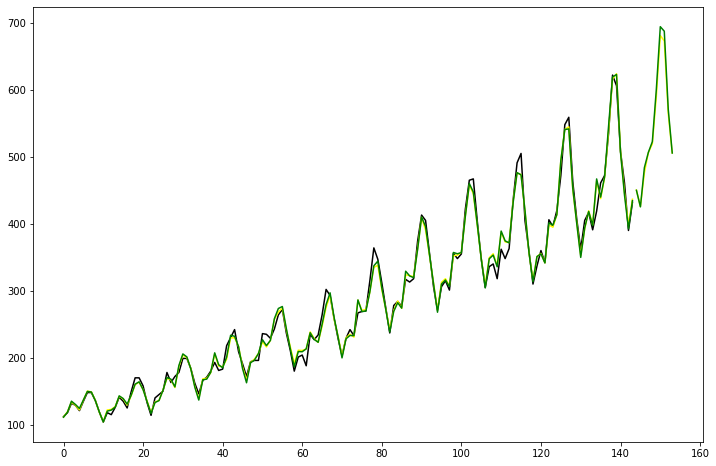

In [171]:
# plot
airP.plot(color="black", figsize=(12,8))

fit0.fittedvalues.plot(color='yellow')
fcast0Hw.plot(color='yellow')

fit1.fittedvalues.plot(color='green')
fcast1Hw.plot(color='green')

#fit2.fittedvalues.plot(color='red')
#fcast2Hw.plot(color='red')

#fit3.fittedvalues.plot(color='skyblue')
#fcast3Hw.plot(color='skyblue')

plt.show()

In [169]:
# parameter comparison
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit0.params[p] for p in params] + [fit0.sse]
results["Multiplicative"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Additive Dam"]   = [fit2.params[p] for p in params] + [fit2.sse]
results["Multiplica Dam"] = [fit3.params[p] for p in params] + [fit3.sse]

results

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,3.468951e-01,3.677103e-01,3.454065e-01,3.648516e-01
$\beta$,1.889013e-09,1.497187e-11,2.851764e-17,5.305963e-14
$\phi$,NaN,NaN,9.987696e-01,9.993018e-01
$\gamma$,5.548654e-01,4.269594e-01,5.555191e-01,4.297943e-01
$l_0$,8.211983e+00,8.290824e+00,8.208458e+00,8.290436e+00
$b_0$,2.209476e-02,2.644232e-02,2.414559e-02,2.782044e-02
SSE,1.657339e+04,1.599625e+04,1.653980e+04,1.596119e+04
